Marcin Wardyński  
wtorek, 9:45

## Laboratorium 7
### 7.4 AE


#### Funkcje pomocnicze
Używany do tej pory plik z funkcjami pomocniczymi do załadowania danych posiada równiez funkcję `get_dataset_for_ae`, która w odróżnieniu od tej używanej dla RBM nie przeprowadza binaryzacji, a jedynie normalizuje zbriory danych.

In [15]:
import warnings
warnings.filterwarnings("ignore")

import importlib
import lab7_utils as utils
importlib.reload(utils)

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

seed = 42

Poniższa klasa `FrozenEncoder` pozwala wykluczyć podany przy inicjalizacji enkoder z dopasowywania wag, oraz dopasowuje interfejs enokdera, aby dało się go użyć w pipeline-ach.  
Funckja `viz_score_to_latent_dim` przedstawia zwizualizowane wyniki klasfykikacji przeprowadzonej danym ekoderem w zależności od wielkości warstwy latentnej.

In [133]:
from sklearn.base import BaseEstimator, TransformerMixin
import matplotlib.pyplot as plt

class FrozenEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, encoder):
        self.encoder = encoder

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return self.encoder.predict(X)
    
    
def viz_score_to_latent_dim(latent_dims, scores_1, scores_2, metric_name, score_1_name, score_2_name):

    plt.figure(figsize=(8, 5))
    scores_1 = sorted(scores_1, key=lambda x: x[0])
    x, y = zip(*scores_1)
    plt.plot(x, y, label=score_1_name, color="red", linestyle="-", marker="o")
    if scores_2:
        scores_2 = sorted(scores_2, key=lambda x: x[0])
        x, y = zip(*scores_2)
        plt.plot(x, y, label=score_2_name, color="blue", linestyle="-", marker="o")
    plt.title(f"{metric_name} - Lattent Layer Dimension")
    plt.xlabel("Lattent Layer Dimension")
    plt.ylabel(f"{metric_name}")
    plt.legend()
    plt.show()

    for i in range(len(scores_1)):
        print(f"[{scores_1[i][0]} -> {score_1_name}: {scores_1[i][1]:.4f}", end="")
        if scores_2:
            print(f", {score_2_name}: {scores_2[i][1]:.4f}", end="")
        print("]")
    print()

`evaluate_autoencoder` opakowuje podany autoenkoder w obiekt `KerasRegressor`, który to pozwala używać sieci neuronowej zbudowanej w oparciu o elementy z biblioteki `keras` w niektórych strukturach ze `sklearn` wspierających trenowanie modeli, jak np. `GridSearchCV`.

In [98]:
import keras

from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV

def evaluate_autoencoder(dataset_name, params, create_ae_fun):

    X_train, X_test, y_train, y_test = utils.get_dataset_for_ae(dataset_name=dataset_name, with_val=False)

    keras_reg = KerasRegressor(
        model=create_ae_fun,
        loss="binary_crossentropy",
        optimizer="adam",
        optimizer__learning_rate=0.001,
        model__latent_dim=128,
        verbose=False,
    )

    grid_search = GridSearchCV(keras_reg, params, cv=7, n_jobs=5)
    grid_search.fit(X_train, X_train)

    r2_scores = np.array(grid_search.cv_results_['mean_test_score'])
    latent_dims = np.array(list(map(lambda t: t['model__latent_dim'], grid_search.cv_results_['params'])))
    
    
    viz_score_to_latent_dim(latent_dims, list(zip(latent_dims, r2_scores)), None, "R2", "mean_val", None)
    

Poniższy zbiór funkcji służy do wypróbowania kilku wariantów autoenkodera, co do jakości klasyfikacji przy użyciu zawartego w nim enkodera, w zależności od rozmiaru warstwy latentnej.
Zależałó mi na zachowaniu procesu, gdzie to cały autoenkoder jest trenowany, a jedynie ewaluacja na danych testowych przebiega przy użyciu wyciągniętego z niego enkodera, a skoro ewaluacja jakości klasyfikacji w zależności od wielkości warstwy latentnej przebiegała na innym modelu, niż ten który był trenowany, trudno mi było ubrać taką konfigurację w wyszukiwanie siatkowe, lub też pipeline, a skorzystałem z konwencjonalnego wykonania wielowątkowego dla różnych rozmiarów warstwy latentnej.

Blok ten dodatkowo prezentuje wyniki treningu autoenkodera na wykresie, oraz przedstawia raport klasyfikacji.

In [132]:
from sklearn.base import clone
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from threading import Lock
from concurrent.futures import ThreadPoolExecutor, wait

def create_model_instance(class_name, *args, **kwargs):
    return class_name(*args, **kwargs)

def check_pipeline(frozen_model, head_model, results, training_progress, latent_dim, X_train, X_test, y_train, y_test, lock):
    pipeline = Pipeline([
        ('frozen_model', frozen_model),
        ('head_model', head_model)
    ])

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    lock.acquire()
    try:
        results['accuracies'].append((latent_dim, accuracy))
        if results['max_accuracy'] < accuracy:
            results['max_accuracy'] = accuracy
            results['best_latent_dim'] = latent_dim
            results['best_model_training_progress'] = training_progress
            results['report'] = classification_report(y_test, y_pred)
    finally:
        lock.release()
        

def viz_training_progress(training_progress, model_name, head_name, dataset_name):
    plt.title(f"Train {model_name} for pipeline with {head_name} using dataset: {dataset_name}")
    plt.plot(training_progress.history['loss'], label='Train Loss')
    plt.plot(training_progress.history['val_loss'], label='Val Loss')
    plt.legend()
    plt.show()

def find_and_eval_best_encoder(dataset_name, model_class, latent_dims, log_reg, rand_frst):
    X_train, X_val, X_test, y_train, y_val, y_test = utils.get_dataset_for_ae(dataset_name, with_val=True)

    log_reg_res = {'max_accuracy': 0, 'accuracies': [], 'best_latent_dim': 0, 'best_model_training_progress': None, 'report': None}
    rand_frst_res = {'max_accuracy': 0, 'accuracies': [], 'best_latent_dim': 0, 'best_model_training_progress': None, 'report': None}

    def process_latent_dim(latent_dim, lock):
        model = create_model_instance(model_class, latent_dim)
        model.compile(optimizer=tf.keras.optimizers.Adam(), loss=keras.losses.BinaryCrossentropy())
        training_progress = model.fit(
            X_train, X_train,
            epochs=40,
            shuffle=True,
            batch_size=64,
            verbose=0,
            validation_data=(X_val, X_val)
        )

        frozen_model = FrozenEncoder(encoder=model.encoder)
        try:
            log_reg_clone = clone(log_reg)
            check_pipeline(frozen_model, log_reg_clone, log_reg_res, training_progress, latent_dim, X_train, X_test, y_train, y_test, lock)
            rand_frst_clone = clone(rand_frst)
            check_pipeline(frozen_model, rand_frst_clone, rand_frst_res, training_progress, latent_dim, X_train, X_test, y_train, y_test, lock)
        except Exception as e:
            print(f"An error occurred: {e}")

    lock = Lock()
    with ThreadPoolExecutor(max_workers=len(latent_dims)) as executor:
        futures = [executor.submit(process_latent_dim, latent_dim, lock) for latent_dim in latent_dims]
        wait(futures)
 
    viz_score_to_latent_dim(latent_dims, log_reg_res['accuracies'], rand_frst_res['accuracies'], "Accuracy", "w. Log-Reg", "w. Rand-Frst")

    viz_training_progress(log_reg_res['best_model_training_progress'], model_class.__name__, "Logical Regression", dataset_name)
    print(f"--- {model_class.__name__} with Logistic Regression ---")
    print(log_reg_res['report'])

    viz_training_progress(rand_frst_res['best_model_training_progress'], model_class.__name__, "Random Forest", dataset_name)
    print(f"--- {model_class.__name__} with Random Forest ---")
    print(rand_frst_res['report'])

### Simple Autoencoder

Poniżej znajduje się prosty model autoenkodera z trzema warstwami sieci MLP przed i po warstwie latentnej. Wypróbowałem również model o dwóch dodatkowych warstwie, ale był on trochę słabszy, a sprawozdanie urosło już do takich rozmiarów, że postanowiłem tych wyników nie zamieszczać.

In [57]:
class SimpleAutoencoder3L(tf.keras.Model):
  def __init__(self, latent_dim):
    super(SimpleAutoencoder3L, self).__init__()
    self.latent_dim = latent_dim
    self.mid_dim = 192
    self.boarder_dim = 384
    self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(shape=(784, )),
            tf.keras.layers.Dense(self.boarder_dim, activation=tf.nn.relu),
            tf.keras.layers.Dense(self.mid_dim, activation=tf.nn.relu),
            tf.keras.layers.Dense(latent_dim, activation=tf.nn.relu),
        ]
    )
    self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(shape=(latent_dim,)),
            tf.keras.layers.Dense(self.mid_dim, activation=tf.nn.relu),
            tf.keras.layers.Dense(self.boarder_dim, activation=tf.nn.relu),
            tf.keras.layers.Dense(units=784, activation=tf.nn.sigmoid),
        ]
    )

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded    

def create_simple_ae_as_sequence(latent_dim):
  model =  SimpleAutoencoder(latent_dim)
  return tf.keras.Sequential([model.encoder, model.decoder])

Ostatnie parametry przed treningiem, a mianowicie wielkości warstw latentnych oraz ilość epok dla treningu.

In [27]:
latent_dims = [10, 64, 128, 256, 512]

param_grid = {
    'model__latent_dim': latent_dims,
    'epochs': [40]
}

Dla każdego zbioru danych chciałem sprawdzić następujące wyniki:
- jakość rekonstrukcji obrazu wejściowego w zależności od wielkości warstwy latentnej
- jakość klasyfikacji przy użyciu enkodera, również w zależności od wielkości warstwy latentnej
- porównać, czy autoenkoder o najlpeszych parametrach okaże się zarazem najlepszym klasyfikatorem

W związku z powyższymi punktami, dla każdego zbioru danych trenuję w pierwszej kolejności sam autoenkoder i prezentuję jego metrykę $R^2$ w zależności od wielkości warstwy latentnej - do tego celu używam wyszkiwania siatkowego.  
Następnie ponawiam trening dla każdego modelu autoenkodera, aby wydobyć z niego enkoder, zamrozić w nim wagi i użyć w pipeline-ie z głową klasyfikującą w postaci regresji logistycznej lub lasu losowego. Wyniki `accuracy` dla klasyfikacji również umieszczam na wykresie, a dla najlepszego enkodera prezentuję raport z jakości klasyfikacji oraz przebieg wartości fnkcji straty w trakcie treningu i walidacji. W sumie tych najlepszych enkoderów może być aż dwa, gdyż w zależności od wybranej metody klasfikacji (głowy), różne modele enkodera mogą sprawdzać się lepiej lub gorzej, co też pokażą nam wygenerowane przeze mnie wykresy.  
Ostatecznie porównam przebieg wszystkich trzech wykresów: całego autoenkodera oraz enkodera z dwiema różnymi metodami klasyfikacji zestawionymi w pipeline.

#### MNIST

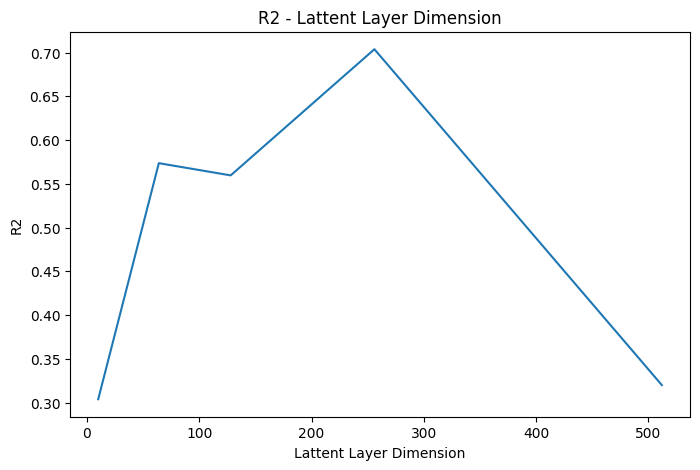

[10: 0.3038] [64: 0.5736] [128: 0.5596] [256: 0.7038] [512: 0.3200] 


In [15]:
evaluate_autoencoder(utils.Dataset_Select.MNIST.value, param_grid, create_simple_ae_as_sequence)

Najlepszą rekonstrukcję danych wejściowych osiągamy dla autoenkodera o 256 neuronach warstwy latentnej. Ciekawy jest spory spadek jakości rekonstrukcji dla 512 neuronów warstwy latentnej.

1608/1608 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step


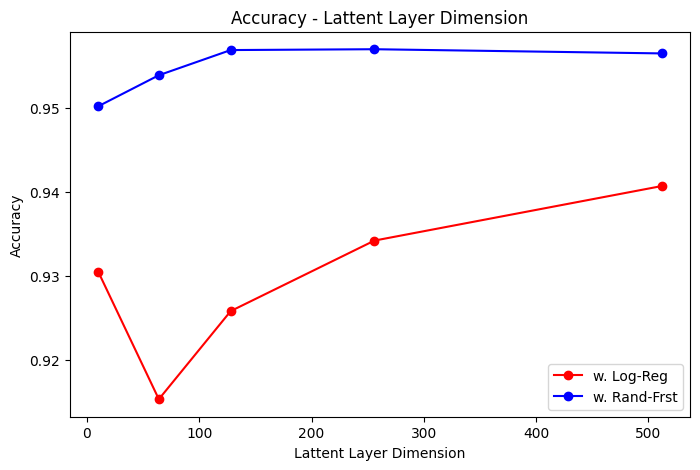

[10 -> w. Log-Reg: 0.9305, w. Rand-Frst: 0.9502]
[64 -> w. Log-Reg: 0.9153, w. Rand-Frst: 0.9539]
[128 -> w. Log-Reg: 0.9258, w. Rand-Frst: 0.9569]
[256 -> w. Log-Reg: 0.9342, w. Rand-Frst: 0.9570]
[512 -> w. Log-Reg: 0.9407, w. Rand-Frst: 0.9565]



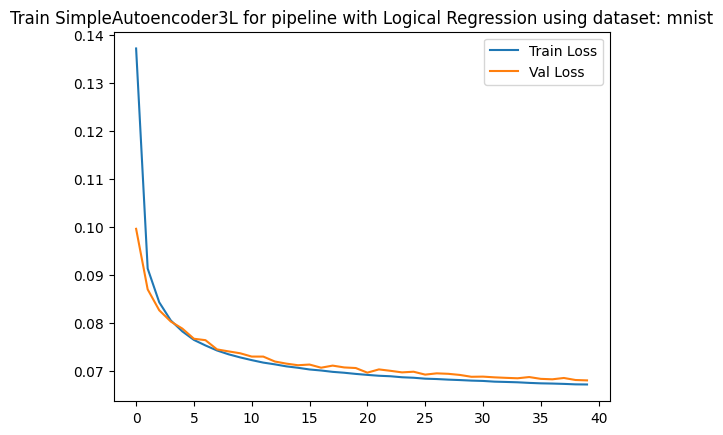

--- SimpleAutoencoder3L with Logistic Regression ---
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       980
           1       0.98      0.98      0.98      1135
           2       0.93      0.93      0.93      1032
           3       0.92      0.94      0.93      1010
           4       0.94      0.93      0.94       982
           5       0.92      0.91      0.92       892
           6       0.95      0.96      0.95       958
           7       0.94      0.94      0.94      1028
           8       0.93      0.92      0.92       974
           9       0.92      0.91      0.92      1009

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000



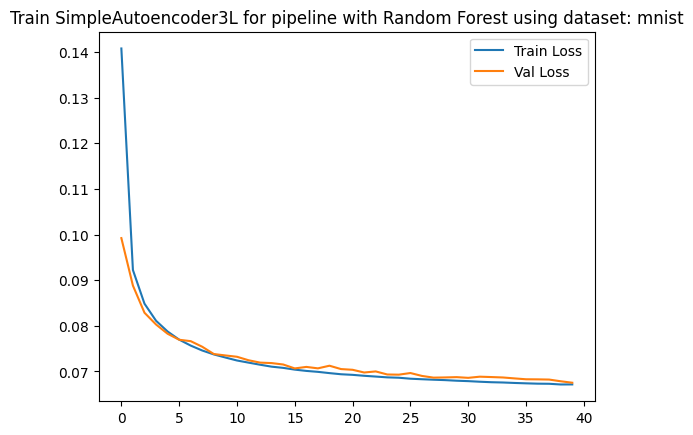

--- SimpleAutoencoder3L with Random Forest ---
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.94      0.95      0.95      1032
           3       0.94      0.95      0.94      1010
           4       0.96      0.96      0.96       982
           5       0.96      0.93      0.95       892
           6       0.97      0.98      0.97       958
           7       0.96      0.94      0.95      1028
           8       0.93      0.94      0.94       974
           9       0.94      0.93      0.94      1009

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000



In [58]:
log_reg = LogisticRegression(max_iter=1000, solver="newton-cg")
rand_frst = RandomForestClassifier(n_estimators=250, random_state=seed)
find_and_eval_best_encoder(utils.Dataset_Select.MNIST.value, SimpleAutoencoder3L, latent_dims, log_reg, rand_frst)

Wybrane enkodery do ekstrakcji cech:
- dla regresji logistycznej: 512 neuronów warstwy latentnej
- dla lasu losowego: 256 neurony warstwy latentnej

Na powyższych wykresach widać jasno, że najlepsze autoenkodery dla poszczególnych hiperparametrów ładnie zbiegają w trakcie treningu i przerwanie treningu po 40 epokach jest zasadne, gdyż wykres wartości funkcji straty jest już dość płaski.

Głowa w postaci regresji logistycznej daje gorsze wyniki od lasu losowego. Co ciekawe, wykres `accuracy` nie rośnie nieustannie wraz ze wzrostem liczby neuronów warstwy latentnej. Z początkowego `accuracy=0.93` przy 10 neuronach latentnych, wartość ta spada poniżej 0.93 dla 64 i 128 neuronów, aby później osiągnąć jeszcze lepsze rezultaty dla 256 i 512 neuronów w warstwie latentnej. Najlepszy wynik przy regresji logistycznej otrzymujemy dla 512 neuronów i wynosi on `accuracy=0.94`.  
W tym wypadku, wybierając najlepszy enkoder na podstawie jakości rekonstrukcji całego autoenkodera, nie przyniosłaby nam najlepszych wyników podczas klasyfikacji, a linie przebiegu metryk $R^2$ i `accuracy` mocno się rozjeżdzają.

Użycie lasu losowego jako modelu klasyfikującego daje dużo lepsze wyniki, a wśród przebadanych modeli enkodera, najlepszą bazą dla głowy w postaci lasu losowego są enkodery o rozmiarze 128 i 256 neuronów w warstwie latentnej, z delikatną przewagą tego drugiego. `Accuracy` najlepszego enkodera wspomaganego w tym wypadku, to 0.96.  
W tym wypadku widać pewną korelację pomiędzy liniami wartości metryk $R^2$ i `accuracy`, a wybór enkodera z najlepiej ocenionego autoenkodera faktycznie daje najlepsze wyniki klasyfikacji.

Wytrenowany autoenkoder nie pobił bardzo wyśróbowanego wyniku RBM, ani DBN `accuracy=0.97`, lecz wynik 0.96 dla zasosowanego lasu losowego, to też dobry rezultat.

#### Fashion MNIST

/Users/mwardynski/Documents/ds/_semestr_9/uczenie_maszynowe/labs/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/mwardynski/Documents/ds/_semestr_9/uczenie_maszynowe/labs/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/mwardynski/Documents/ds/_semestr_9/uczenie_maszynowe/labs/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/mwardynski/Documents/ds/_semestr_9/uczenie_maszynow

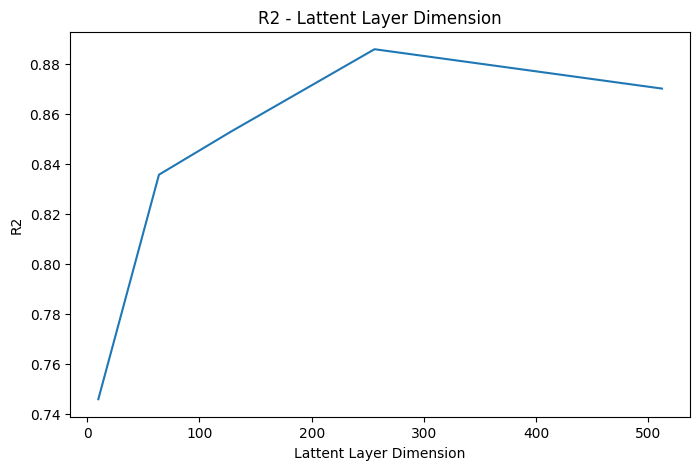

[10: 0.7459] [64: 0.8356] [128: 0.8528] [256: 0.8857] [512: 0.8700] 


In [19]:
evaluate_autoencoder(utils.Dataset_Select.F_MNIST.value, param_grid, create_simple_ae_as_sequence)

Jak i dla zbioru MNIST, również rekonstrukcja Fashion-MNIST przebiega najlepiej dla autoenkodera o 256 neuronach w warstwie latentnej, natomiast spadek jakości klasyfilacji nie jest aż tak gwałtowny dla 512 neuronów.

1608/1608 ━━━━━━━━━━━━━━━━━━━━ 1s 551us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 648us/step
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 1s 507us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 1s 496us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 1s 496us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 526us/step
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 1s 552us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 524us/step
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 1s 569us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 516us/step
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 1s 536us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 671us/step
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 1s 516us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 547us/step
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 1s 585us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 598us/step
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 1s 588us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step


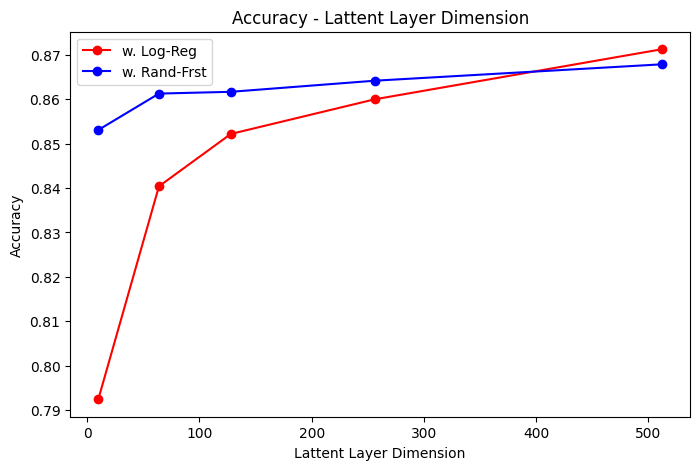

[10 -> w. Log-Reg: 0.7924, w. Rand-Frst: 0.8531]
[64 -> w. Log-Reg: 0.8404, w. Rand-Frst: 0.8613]
[128 -> w. Log-Reg: 0.8522, w. Rand-Frst: 0.8617]
[256 -> w. Log-Reg: 0.8600, w. Rand-Frst: 0.8642]
[512 -> w. Log-Reg: 0.8713, w. Rand-Frst: 0.8679]



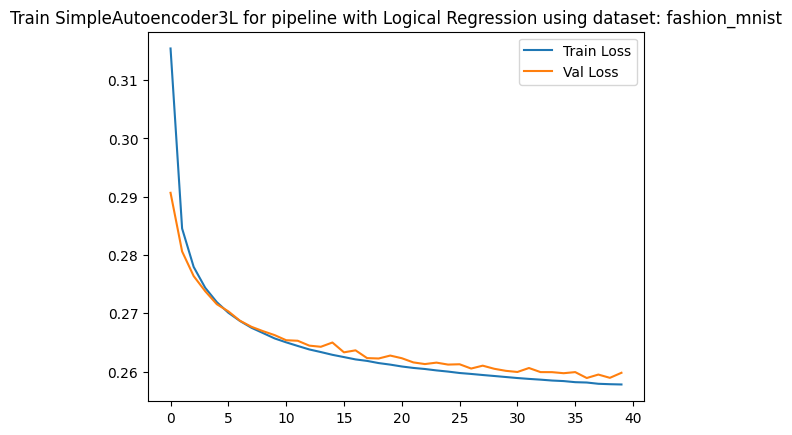

--- SimpleAutoencoder3L with Logistic Regression ---
              precision    recall  f1-score   support

           0       0.81      0.85      0.83      1000
           1       0.98      0.97      0.98      1000
           2       0.75      0.78      0.77      1000
           3       0.88      0.89      0.88      1000
           4       0.78      0.78      0.78      1000
           5       0.97      0.95      0.96      1000
           6       0.69      0.62      0.65      1000
           7       0.93      0.95      0.94      1000
           8       0.96      0.97      0.97      1000
           9       0.95      0.95      0.95      1000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



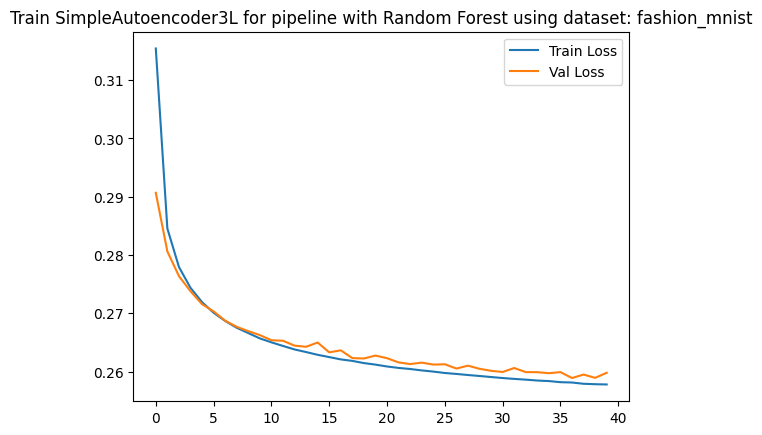

--- SimpleAutoencoder3L with Random Forest ---
              precision    recall  f1-score   support

           0       0.80      0.85      0.83      1000
           1       1.00      0.95      0.97      1000
           2       0.76      0.80      0.78      1000
           3       0.86      0.90      0.88      1000
           4       0.77      0.81      0.79      1000
           5       0.96      0.93      0.95      1000
           6       0.71      0.57      0.63      1000
           7       0.92      0.95      0.93      1000
           8       0.94      0.97      0.95      1000
           9       0.94      0.96      0.95      1000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



In [60]:
log_reg = LogisticRegression(max_iter=1000, solver="newton-cg")
rand_frst = RandomForestClassifier(n_estimators=250, random_state=seed)
find_and_eval_best_encoder(utils.Dataset_Select.F_MNIST.value, SimpleAutoencoder3L, latent_dims, log_reg, rand_frst)

Wybrane enkodery do ekstrakcji cech:
- dla regresji logistycznej: 512 neuronów warstwy latentnej
- dla lasu losowego: 512 neuronów warstwy latentnej

Zbieżność treningu dla treningowej części zbioru danych zachowuje się bardzo regularnie i z każdą epoką funkcja straty przyjmuje mniejsze wartości. Natomiast dla zbioru walidacyjnego postęp treningu nie jest równie regularny - aż do epoki 35 widzimy regularny spadek wartości funkcji straty, a ostatnie 5 epok treningu niespecjalnie przyczynia się do poprawy klasyfikacji na zbiorze walidacyjnym.

Jakość klasyfikacji przy zastosowaniu regresji logistycznej jest ściśle powiązana z ilością neuronów w warstwie latentnej i wraz ze wzrostem ich liczebności, również rośnie. Najlepszy wynik otrzymujemy dla 512 neuronów i wynosi on `accuracy=0.87` i jest zarazem najlepszy wynik z dwóch badanych głów klasyfikujących, ale dla mniejszych rozmiarów warst latentnych, regresja logisticzna sprawowała się słabiej od lasu losowego.  
Jak widzimy, wybranie enkodera z autoenkodera o najlepszej jakości rekonstrukcji danych wejściowych zwróciłoby `accuracy` niższe o prawie 2p.p.

Głowa klasyfikująca w postaci lasu losowego sprawuje się dla dla większości badanych wartości hiperparametrów lepiej, niż regresja logistyczna, aby ostatecznie ustąpić jej minimalnie przy 512 neuronach warstwy latentnej. Generalnie las losowy potrafi wydobyć bardzo dobrą jakość klasyfikacji niezależnie czy warstwa latenta ma 10, czy 512 neuronów, ale najlepszy wynik o `accuracy` niemalże 0.87 uzyskano dla największej warstwy latentnej.
Ten wynik również nie pokrywa się z enkoderem wybranym z najlepszego autoenkodera.

W tym wypadku autoenkoder okazał się dużo lepszym ekstraktorem cech dla dalszej klasyfikacji, niż RBM czy też DBN, które osiągnęły odpowiednio 0.84 i 0.83. Tak dużą poprawę zawdzięczamy najpewniej dużej stracie informacji po binaryzacji danych dla RBM.

#### Kuzushiji MNIST

2025-01-05 02:29:16.656988: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:376] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2025-01-05 02:29:21.193868: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-05 02:29:21.993140: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
/Users/mwardynski/Documents/ds/_semestr_9/uczenie_maszynowe/labs/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/mwardynski/Documents/ds/_semestr_9/uczenie_maszynowe/labs/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, current

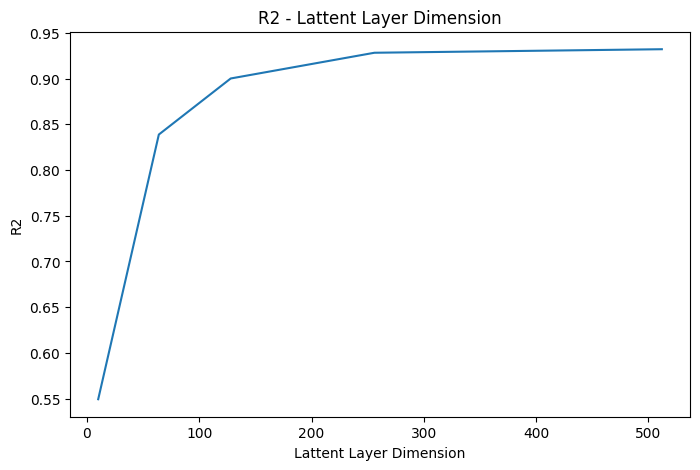

[10: 0.5494] [64: 0.8388] [128: 0.9001] [256: 0.9282] [512: 0.9321] 


In [22]:
evaluate_autoencoder(utils.Dataset_Select.K_MNIST.value, param_grid, create_simple_ae_as_sequence)

Po raz pierwszy widzimy nieustanny wzrost jakości obrazów wygenerowanych przez autoenkoder, przez co najlepszym autoenkoderem jest ten o 512 neuronach w warstwie latentnej, aczkolwiek przebieg wykresu dla ostatnich wartości bardzo się wypłaszcza. 

1608/1608 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step   
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 2s 990us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 1s 888us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 1s 703us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 822us/step
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 1s 661us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step


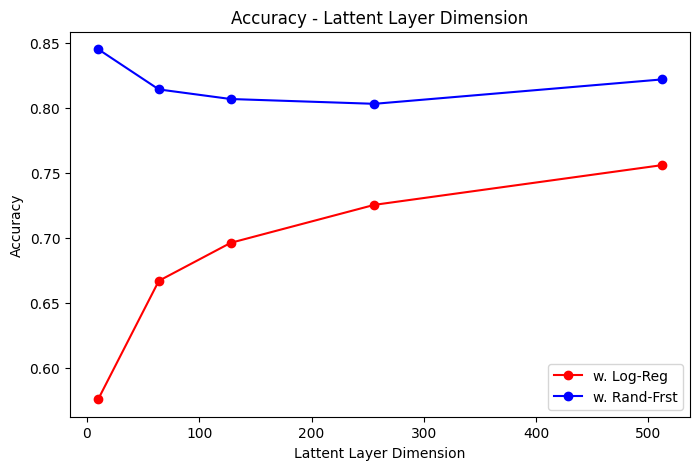

[10 -> w. Log-Reg: 0.5756, w. Rand-Frst: 0.8455]
[64 -> w. Log-Reg: 0.6669, w. Rand-Frst: 0.8145]
[128 -> w. Log-Reg: 0.6962, w. Rand-Frst: 0.8071]
[256 -> w. Log-Reg: 0.7255, w. Rand-Frst: 0.8034]
[512 -> w. Log-Reg: 0.7561, w. Rand-Frst: 0.8222]



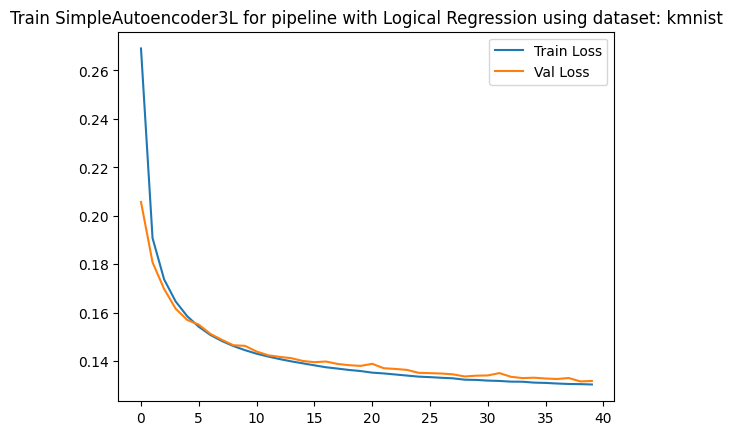

--- SimpleAutoencoder3L with Logistic Regression ---
              precision    recall  f1-score   support

           0       0.86      0.80      0.83      1000
           1       0.71      0.75      0.73      1000
           2       0.64      0.70      0.67      1000
           3       0.82      0.84      0.83      1000
           4       0.69      0.69      0.69      1000
           5       0.85      0.76      0.80      1000
           6       0.73      0.81      0.77      1000
           7       0.81      0.70      0.75      1000
           8       0.71      0.78      0.75      1000
           9       0.78      0.74      0.76      1000

    accuracy                           0.76     10000
   macro avg       0.76      0.76      0.76     10000
weighted avg       0.76      0.76      0.76     10000



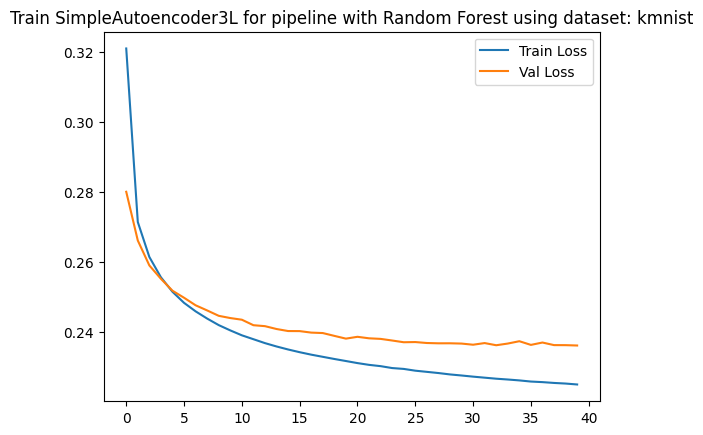

--- SimpleAutoencoder3L with Random Forest ---
              precision    recall  f1-score   support

           0       0.88      0.85      0.87      1000
           1       0.81      0.86      0.83      1000
           2       0.76      0.80      0.78      1000
           3       0.89      0.92      0.90      1000
           4       0.82      0.79      0.80      1000
           5       0.95      0.78      0.86      1000
           6       0.79      0.92      0.85      1000
           7       0.88      0.84      0.86      1000
           8       0.82      0.86      0.84      1000
           9       0.91      0.83      0.87      1000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



In [59]:
log_reg = LogisticRegression(max_iter=1000, solver="newton-cg")
rand_frst = RandomForestClassifier(n_estimators=250, random_state=seed)
find_and_eval_best_encoder(utils.Dataset_Select.K_MNIST.value, SimpleAutoencoder3L, latent_dims, log_reg, rand_frst)

Wybrane enkodery do ekstrakcji cech:
- dla regresji logistycznej: 512 neuronów warstwy latentnej
- dla lasu losowego: 10 neuronów warstwy latentnej

Zbieżność treningu najlepszych wariantow klasyfikatorów jest zachowana, aczkolwiek przy zastosowaniu regresji logistycznej jako głowy, wartości wartości funkcji kosztu dla zbioru walidacyjnego lepiej podążają za wartościami zbioru treningowego wraz z kolejnymi epokami, za to dla lasu losowego wartości funkcji kosztu bardzo się wypłaszczają już po 20. epoce.

Jakośc klasyfikacji z użyciem regresji logistycznej jako głowy rośnie wraz ze wzrostem warstwy latentnej użytego enkodera, jednakże nawet dla największego rozmiaru nie pokonuje choćby i najgorszej wartości klasyfikacji głową w postaci lasu losowego. Regresja logistyczna w połączeniu z najlepszym enkoderem osiąga `accuracy` jedynie 0.76, co jest dość kiepskim wynikiem.  
Wykres przyrostu `accuracy` odpowiada kształtowi wykresu przyrostu $R^2$ a więc w tym wypadku enkoder z najlepiej ocenionego autoenkodera przyniósłby najlepszą klasyfikację.

Bardzo ciekawie wygląda wykres dla klasyfikatora z lasem losowym jako głowa klasyfikatora. Otóż najlepsze `accuracy=0.85` otrzymujemy dla najmniejszej wielkości warstwy latentnej enkodera, po czym wartości `accuracy` spadają osiągając lokalne minimum dla 256 neuronów i ponownie zaczynają rosnąć.
W tym wypadku pobranie enkodera z najlepiej ocenionego autoenkodera byłoby bardzo chybionym pomysłem, gdyż jak się okazuje, enkoder najlepiej wspomagający klasyfikację pochodzi z najgorzej ocenianego autoenkodera.

Wyniku klasyfikacji enkoderem w zestawieniu z regresją logiczną lepiej nie powtarzać, ale nawet zastosowanie lasu losowego nie pozwoliło dorównać wynikom RBN i DBN, które były lepsze o odpowiednio 1 i 2 p.p.

### Kuzushiji-49

6220/6220 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
6220/6220 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step
6220/6220 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step
6220/6220 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
6220/6220 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
6220/6220 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
6220/6220 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
6220/6220 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
6220/6220 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 1s 812us/step
6220/6220 ━━━━━━━━━━━━━━━━━━━━ 5s 869us/step
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 1s 781us/step
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 1s 685us/step
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 1s 620us/step
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 1s 642us/step


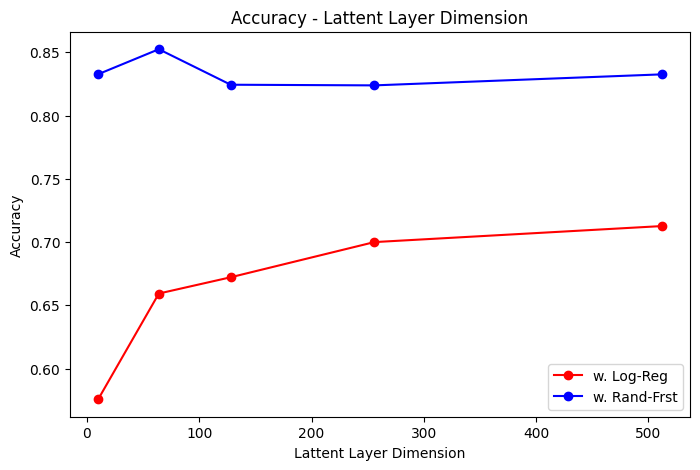

[10 -> w. Log-Reg: 0.5758, w. Rand-Frst: 0.8327]
[64 -> w. Log-Reg: 0.6593, w. Rand-Frst: 0.8524]
[128 -> w. Log-Reg: 0.6722, w. Rand-Frst: 0.8244]
[256 -> w. Log-Reg: 0.7000, w. Rand-Frst: 0.8239]
[512 -> w. Log-Reg: 0.7127, w. Rand-Frst: 0.8326]



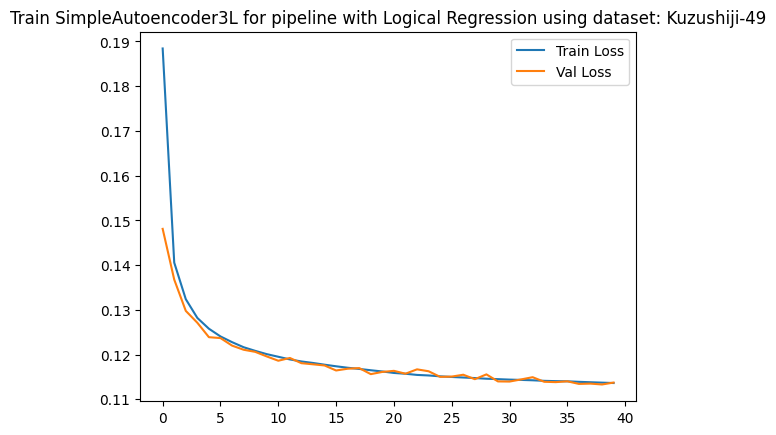

--- SimpleAutoencoder3L with Logistic Regression ---
              precision    recall  f1-score   support

           0       0.67      0.68      0.68       995
           1       0.84      0.87      0.85       962
          10       0.76      0.76      0.76      1052
          11       0.78      0.78      0.78       970
          12       0.54      0.51      0.53       960
          13       0.77      0.81      0.79       669
          14       0.70      0.71      0.71       629
          15       0.62      0.56      0.59      1012
          16       0.74      0.78      0.76       425
          17       0.68      0.76      0.72       953
          18       0.80      0.83      0.82       976
          19       0.69      0.73      0.71      1046
           2       0.76      0.85      0.81      1020
          20       0.65      0.62      0.64      1066
          21       0.68      0.60      0.64       954
          22       0.75      0.72      0.73       321
          23       0.63     

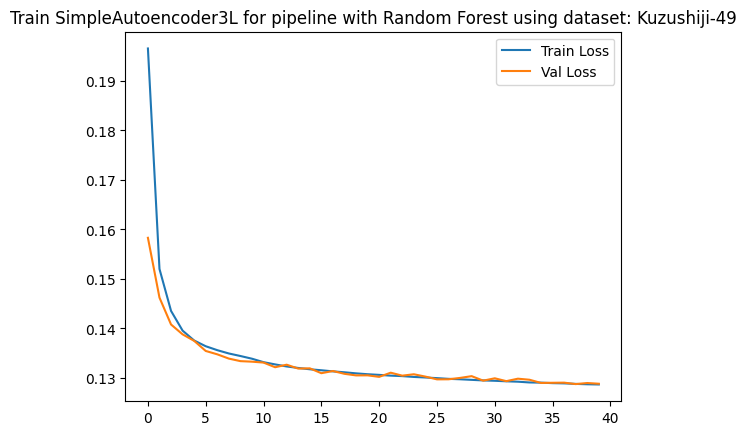

--- SimpleAutoencoder3L with Random Forest ---
              precision    recall  f1-score   support

           0       0.80      0.92      0.86       995
           1       0.90      0.95      0.92       962
          10       0.89      0.87      0.88      1052
          11       0.91      0.87      0.89       970
          12       0.83      0.84      0.83       960
          13       0.81      0.87      0.84       669
          14       0.85      0.80      0.82       629
          15       0.87      0.80      0.83      1012
          16       0.89      0.90      0.89       425
          17       0.79      0.90      0.84       953
          18       0.87      0.89      0.88       976
          19       0.84      0.87      0.85      1046
           2       0.83      0.92      0.87      1020
          20       0.79      0.80      0.80      1066
          21       0.85      0.79      0.82       954
          22       0.89      0.78      0.83       321
          23       0.87      0.75 

In [136]:
log_reg = LogisticRegression(max_iter=1000, solver="newton-cg")
rand_frst = RandomForestClassifier(n_estimators=250, random_state=seed)
find_and_eval_best_encoder(utils.Dataset_Select.KUZ_49.value, SimpleAutoencoder3L, latent_dims, log_reg, rand_frst)

Wybrane enkodery do ekstrakcji cech:
- dla regresji logistycznej: 512 neuronów warstwy latentnej
- dla lasu losowego: 64 neurony warstwy latentnej

Przebieg wykresu wartości funkcji kosztu zarówno dla danych treningowych i walidacyjnych, dla obydwu wyselekcjonowanych modeli przybiera pożądany kształt potwierdzający coraz mniejszy zysk z treningu przy kolejnych epokach.

Podobnie jak w przypadku zbioru danych Kuzushiji-MNIST, również dla Kuzushiji-49 wybrany model enkodera ekstrachujący cechy do dalszej klasyfikacji przez regresję logistyczną dostarcza bardzo słabych wyników. `Accuracy` wynosi zaledwie 0.71 i zostało ono osiągnięte dla enkodera posiadającego 512 neuronów w warstwie latentnej. Dla pozostałych enkoderów wynik ten byłby jeszcze niższy, co przedstawia wykres.

Przy zastosowaniu lasu losowego do klasyfikacji, podobnie jak w Kuzushiji-MNIST, osiągamy dużo lepsze wyniki. `Accuracy=0.85` jest wartością lepszą od tych osiąganych przez RBM oraz DBN, czego należałoby oczekiwać od autoenkodera, a przynajmniej wyniku porównywalnego.

W związku z dużym rozmiarem zbioru Kuzushiji-49, w tym wypadku rezygnuję z wyliczenia wyszukiwaniem siatkowym najwierniej regenerującego wartości wejściowe autoenkodera.

### Autoenkoder konwolucyjny

Zaproponowany przeze mnie autoenkoder konwolucyjny składa się z następujących elementów:

Enkoder:
- rozszerzenie wymiarowości danych wejściowych do 2D
- trzy wartstwy konwolucyjne z funkcją aktywacji ReLU zachowujące wejściowy rozmiar grafiki
- trzech warst MaxPooling działających na obszarze 2x2 - warstwa MaxPooling znajduje się po każdej warstwie konwolucyjnej
- warstwa spłaszczająca
- warstwa gęsta (zwykłe MLP) o zadanym rozmiarze warstwy latentnej

Dekoder:
- warstwa gęsta o 1568 neuronach z aktywacją ReLU, która jest odpowiednia dla następujących po niej warstwach dekonwolucyjnych
- dwie warstwy dekonwolucyjne z funkcją aktywacji RELU 
- jedna warstwa dekonwolucyjna z sigmoidalną funkcją aktywacji, aby powrócić do wejściowego przedziału liczbowego
- wypłaszczenie obrazka 2D do 1D, żeby odpowiadał formatowi wejściowemu

In [134]:
class ConvAutoencoder3Conv_1Dense(tf.keras.Model):
  def __init__(self, latent_dim):
    super(ConvAutoencoder3Conv_1Dense, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.Input(shape=(784,)),
            tf.keras.layers.Reshape(target_shape=(28, 28, 1)),
            tf.keras.layers.Conv2D(32, 3, activation=tf.nn.relu, padding='same'),
            tf.keras.layers.MaxPooling2D(2, padding='same'),
            tf.keras.layers.Conv2D(64, 3, activation=tf.nn.relu, padding='same'),
            tf.keras.layers.MaxPooling2D(2, padding='same'),
            tf.keras.layers.Conv2D(128, 3, activation=tf.nn.relu, padding='same'),
            tf.keras.layers.MaxPooling2D(2, padding='same'),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(latent_dim),
            
        ]
    )
    self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(shape=(latent_dim,)),
            tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
            tf.keras.layers.Reshape((7, 7, 32)),
            tf.keras.layers.Conv2DTranspose(64, 3, 2, activation=tf.nn.relu, padding='same'),
            tf.keras.layers.Conv2DTranspose(32, 3, 2, activation=tf.nn.relu, padding='same'),
            tf.keras.layers.Conv2DTranspose(1, 3, 1, activation=tf.nn.sigmoid, padding='same'),
            tf.keras.layers.Reshape(target_shape=(784,))
        ]
    )

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded
  
def create_conv_ae_as_sequence(latent_dim):
  model =  ConvAutoencoder(latent_dim)
  return tf.keras.Sequential([model.encoder, model.decoder])


Dodatkowo, w dalszej części ćwieczenia rezygnuję z mojego dodatkowego eksperymentu sprawdzającego zasadność wyboru enkodera z najlepiej ocenianego autoenkodera. Już po danych z poprzedniej części mogę stwierdzić, że takie podejście nie zawsze da nam najlepszy enkoder do dalszej klasyfiajcji. Jendakże w moim eksperymencie pominąłem pewne ważne kwestie, jak np. czy wybrany enkoder nie będzie overfitował dla badanego zbioru danych.

W każdym razie, przeprowadzanie wyszukiwania siatkowego dla prostego autoenkodera było dość obciążające obliczeniowo, a dla konwolucyjnego autoenkodera czas pracy będzie jeszcze dłuższy, stąd brak kontynuacji tego etapu. Zebrane do tej pory dane muszą wystarczyć do wyciągnięcia wstępnych wniosków co do przełożenia się jakości odzworowania jakości obrazu wejściowego autoenkodera, na ekstrakcję cech zawartego w nim enkodera.

#### MNIST

1608/1608 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


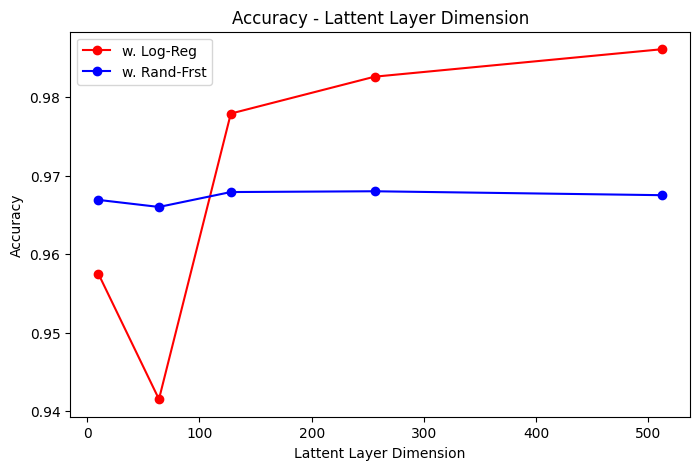

[10 -> w. Log-Reg: 0.9575, w. Rand-Frst: 0.9669]
[64 -> w. Log-Reg: 0.9415, w. Rand-Frst: 0.9660]
[128 -> w. Log-Reg: 0.9779, w. Rand-Frst: 0.9679]
[256 -> w. Log-Reg: 0.9826, w. Rand-Frst: 0.9680]
[512 -> w. Log-Reg: 0.9861, w. Rand-Frst: 0.9675]



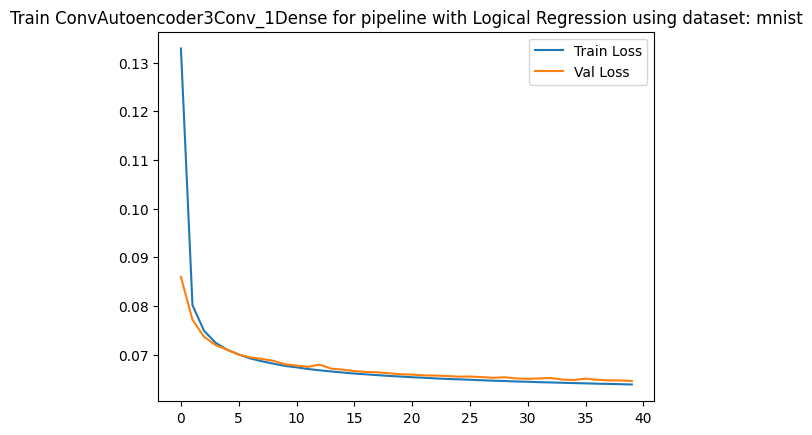

--- ConvAutoencoder3Conv_1Dense with Logistic Regression ---
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.98      0.99      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.98      0.99       892
           6       0.99      0.99      0.99       958
           7       0.98      0.98      0.98      1028
           8       0.98      0.98      0.98       974
           9       0.99      0.98      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



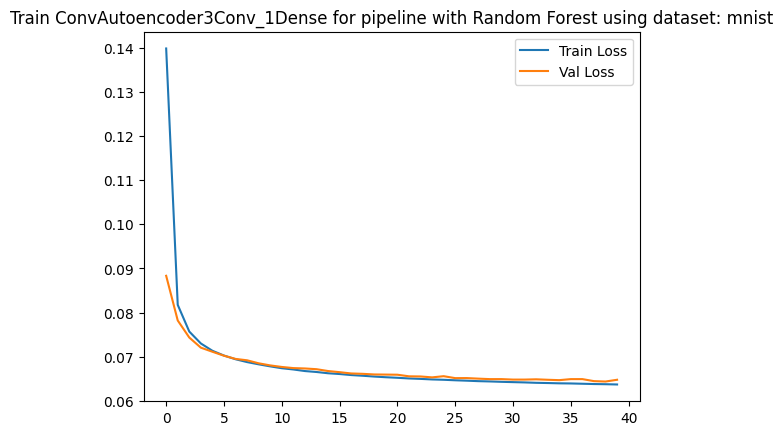

--- ConvAutoencoder3Conv_1Dense with Random Forest ---
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.95      0.97      0.96      1032
           3       0.95      0.96      0.95      1010
           4       0.97      0.98      0.98       982
           5       0.97      0.96      0.97       892
           6       0.98      0.98      0.98       958
           7       0.97      0.95      0.96      1028
           8       0.96      0.95      0.95       974
           9       0.96      0.95      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



In [65]:
log_reg = LogisticRegression(max_iter=1000, solver="newton-cg")
rand_frst = RandomForestClassifier(n_estimators=250, random_state=seed)
find_and_eval_best_encoder(utils.Dataset_Select.MNIST.value, ConvAutoencoder3Conv_1Dense, latent_dims, log_reg, rand_frst)

Wybrane enkodery do ekstrakcji cech:
- dla regresji logistycznej: 512 neuronów warstwy latentnej
- dla lasu losowego: 256 neurony warstwy latentnej

Trenowany model autoenkodera konwolucyjnego zachowuje zbieżność podczas treningu, a wartość funkcji kosztu dla danych ze zbioru walidacyjnego nie odbiegają znaczącą od wartości dla danych zioru treningowego.

Wartości `accuracy` dla klasyfikatora z regresją logistyczną w głowie zachowują się dość nieregularnie, spadając dla 64 neuronów względem 10 neuronów warstwy latentnej, po czym gwałtownie rosnąc dla 128 i więcej neuronów. Najlepszy wynik klasyfikacji osiągamy dla 512 neuronów warstwy latentnej, który to wynosi niemalże 0.99 i jest to najlepszy wynik, jaki udało mi się uzyskać dla zioru MNIST w całym przebiegu laboratorium.

Głowa klasyfikująca w postaci lasu losowego daje niezależnie od ilości neuronów warstwy losowej bardzo podobne wyniki `accuracy`, dryfujące odrobinę poniżej wartości 0.97. Model enkodera o 256 neuronach warstwy latencyjnej został wybrany, jako nejlepszy do użycia z lasem losowym i osiągnął `accuracy=0.97`, czyli właściwie tyle co RBM i DBN, a więcej od Autoenkodera w dwóch wariantach.

#### Fashion MNIST

1608/1608 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


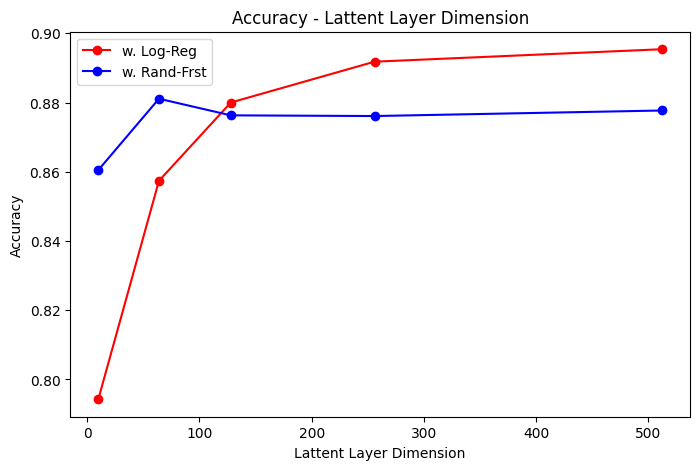

[10 -> w. Log-Reg: 0.7943, w. Rand-Frst: 0.8605]
[64 -> w. Log-Reg: 0.8574, w. Rand-Frst: 0.8811]
[128 -> w. Log-Reg: 0.8800, w. Rand-Frst: 0.8763]
[256 -> w. Log-Reg: 0.8918, w. Rand-Frst: 0.8761]
[512 -> w. Log-Reg: 0.8954, w. Rand-Frst: 0.8777]



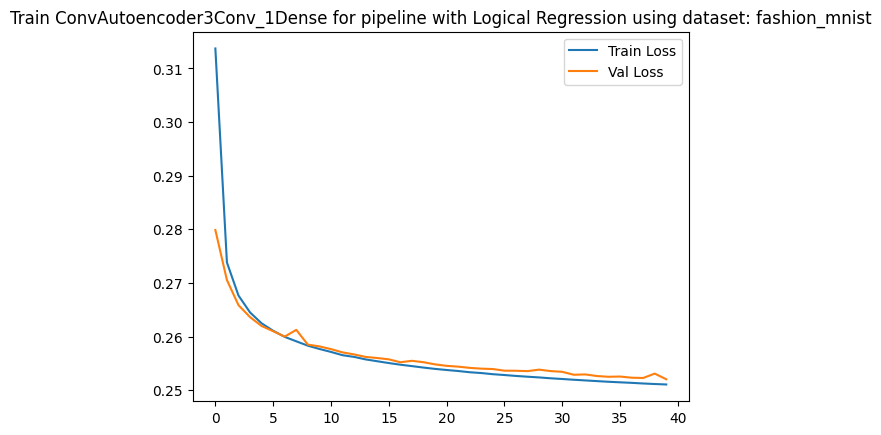

--- ConvAutoencoder3Conv_1Dense with Logistic Regression ---
              precision    recall  f1-score   support

           0       0.83      0.85      0.84      1000
           1       0.99      0.98      0.98      1000
           2       0.82      0.86      0.84      1000
           3       0.89      0.91      0.90      1000
           4       0.82      0.82      0.82      1000
           5       0.97      0.97      0.97      1000
           6       0.73      0.67      0.70      1000
           7       0.94      0.97      0.95      1000
           8       0.98      0.98      0.98      1000
           9       0.97      0.95      0.96      1000

    accuracy                           0.90     10000
   macro avg       0.89      0.90      0.89     10000
weighted avg       0.89      0.90      0.89     10000



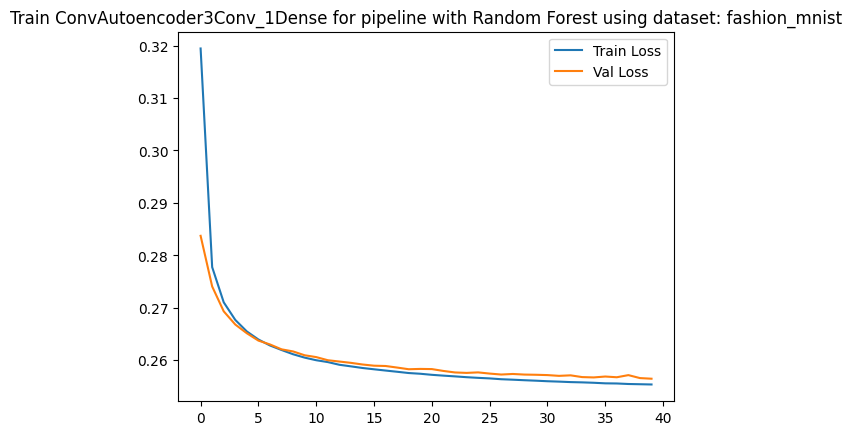

--- ConvAutoencoder3Conv_1Dense with Random Forest ---
              precision    recall  f1-score   support

           0       0.82      0.86      0.84      1000
           1       0.99      0.97      0.98      1000
           2       0.79      0.82      0.80      1000
           3       0.86      0.90      0.88      1000
           4       0.79      0.82      0.81      1000
           5       0.98      0.96      0.97      1000
           6       0.72      0.59      0.65      1000
           7       0.94      0.96      0.95      1000
           8       0.96      0.98      0.97      1000
           9       0.95      0.95      0.95      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



In [63]:
log_reg = LogisticRegression(max_iter=1000, solver="newton-cg")
rand_frst = RandomForestClassifier(n_estimators=250, random_state=seed)
find_and_eval_best_encoder(utils.Dataset_Select.F_MNIST.value, ConvAutoencoder3Conv_1Dense, latent_dims, log_reg, rand_frst)

Wybrane enkodery do ekstrakcji cech:
- dla regresji logistycznej: 512 neuronów warstwy latentnej
- dla lasu losowego: 64 neurony warstwy latentnej

Podobnie do przebiegu klasyfikacji zbioru MNIST, również dla Fashio-MNIST nasz autoenkoder bardzo ładnie zmniejsza wartość funkcji kosztu z każdą kolejną epoką, zarówno dla danych treningowych, jak i walidacyjnych.

Podobnie jak dla poprzedniego zbioru, również i teraz regresja logistyczna klasyfikuje gorzej z modelami enkoderów o mniejszej ilości neuronów warstwy latentnej, aby od pewnego poziomu zapewnić najlepsze wyniki klasyfikacji. Przy 512 neuronach warstwy latentnej osiągamy dokładność klasyfikacji na poziomie 0.90 i jest to ponownie najlepszy rezultat dla zbioru Fashion-MNIST w przebiegu całego laboratorium.

Wartości `accuracy` przy posiłkowniau się lasem losowym do klasyfikacji są ponownie obarczone mniejszą zmiennością względem zmiany ilości neuronów warstwy latentnej. W treningu najlepiej wypadł enkoder o 64 neuronach, który z lasem losowym daje `accuracy=0.88`. Jest to drugi najlepszy wynik zaraz po autoenkoderze konwolucyjnym z regresją logistyczną.

#### Kuzushiji MNIST

2025-01-06 17:39:32.542492: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1608/1608 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


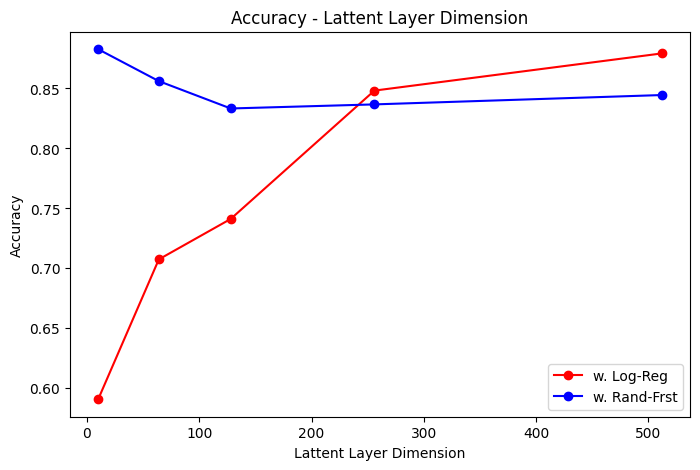

[10 -> w. Log-Reg: 0.5909, w. Rand-Frst: 0.8827]
[64 -> w. Log-Reg: 0.7075, w. Rand-Frst: 0.8561]
[128 -> w. Log-Reg: 0.7412, w. Rand-Frst: 0.8333]
[256 -> w. Log-Reg: 0.8482, w. Rand-Frst: 0.8367]
[512 -> w. Log-Reg: 0.8792, w. Rand-Frst: 0.8445]



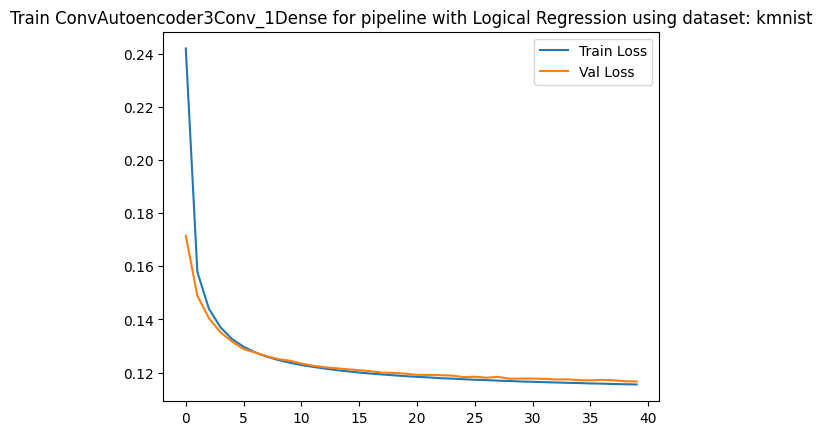

--- ConvAutoencoder3Conv_1Dense with Logistic Regression ---
              precision    recall  f1-score   support

           0       0.92      0.92      0.92      1000
           1       0.88      0.87      0.87      1000
           2       0.80      0.79      0.80      1000
           3       0.90      0.93      0.91      1000
           4       0.84      0.85      0.85      1000
           5       0.93      0.85      0.89      1000
           6       0.82      0.89      0.85      1000
           7       0.91      0.88      0.89      1000
           8       0.88      0.92      0.90      1000
           9       0.91      0.90      0.90      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



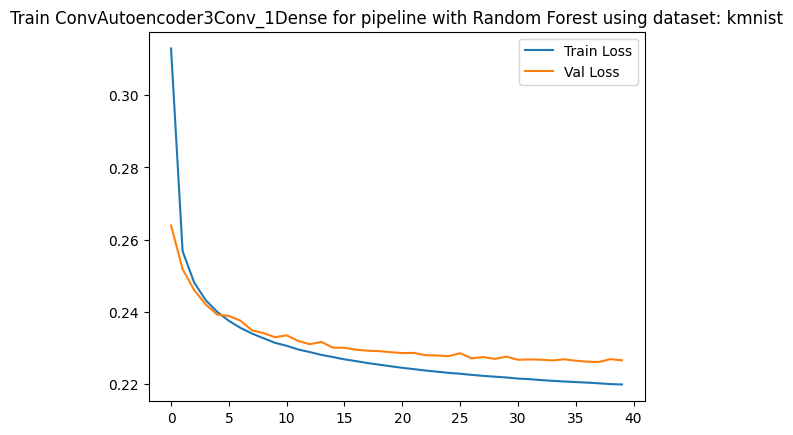

--- ConvAutoencoder3Conv_1Dense with Random Forest ---
              precision    recall  f1-score   support

           0       0.91      0.91      0.91      1000
           1       0.88      0.86      0.87      1000
           2       0.79      0.83      0.81      1000
           3       0.89      0.95      0.92      1000
           4       0.86      0.84      0.85      1000
           5       0.96      0.84      0.90      1000
           6       0.86      0.94      0.89      1000
           7       0.92      0.90      0.91      1000
           8       0.87      0.88      0.87      1000
           9       0.89      0.88      0.88      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



In [50]:
log_reg = LogisticRegression(max_iter=1000, solver="newton-cg")
rand_frst = RandomForestClassifier(n_estimators=250, random_state=seed)
find_and_eval_best_encoder(utils.Dataset_Select.K_MNIST.value, ConvAutoencoder3Conv_1Dense, latent_dims, log_reg, rand_frst)

Wybrane enkodery do ekstrakcji cech:
- dla regresji logistycznej: 512 neuronów warstwy latentnej
- dla lasu losowego: 10 neuronów warstwy latentnej

Analizując przebieg wartości funkcji kosztu widzimy, że dla autoenkodera wykorzystywanego z regresją logistyczną, czyli mającym 512 neuronów warstwy latentnej, wykresy wartości funkcji kosztu dla danych treningowych i walidacyjnych są bardzo sobie bliskie. Natomiast autoenkoder wybrany dla lasu losowego ma tylko 10 neuronów warstwy latentnej i wykres wartości funkcji kosztu dla danych walidacyjnych wypłaszcza się znacznie szybciej, od tego dla danych treningowych.  
Jest to zapewne związane z obserwacją poczynioną już wcześniej, a mianowicie że większa warstwa latentna bardzo często pozwala na lepsze odtworzenie danych wejściowych do autoenkodera, jednakże nie zawsze przekłada się dobrze na jakość enkodera w formie ekstraktora cech w procesie klasyfikacji. Często enkoder o mniejszej liczbie neuronów latentnych, nadaje się lepiej do klasyfikacji, a zwłaszcza jeśli zostanie zestawiony z lasem losowym, co też obserwujemy tym razem.

Podczas treningu, klasyfikator oparty o ekstraktor cech w formie enkodera o 512 neuronach warstwy latentnej sprawił się niewiele gorzej od klasyfikatora wykorzystującego las losowy. W wynikach dla danych testwych obydwa klasyfikatory mają takie samo `accuracy=0.88` i jest to ponownie najlepsza wartość dla jakości klasyfikacji zbioru Kuzushiji-MNIST.

Wynik dla klasyfikatora korzystającego z lasu losowego już znamy, tj. `accuracy=0.88`. Ciekawe jest natomiast, że wynik ten otrzymaliśmy wybierając enkoder o zaledwie 10 neuronach w warstwie latentnej jako ekstraktor cech. Mój stosunek do takiego przebiegu eksperymentu wyraziłem już w pierwszym fragmencie tej sekcji.

### Kuzushiji-49

6220/6220 ━━━━━━━━━━━━━━━━━━━━ 84s 14ms/step
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step
6220/6220 ━━━━━━━━━━━━━━━━━━━━ 86s 14ms/step
6220/6220 ━━━━━━━━━━━━━━━━━━━━ 70s 11ms/step
6220/6220 ━━━━━━━━━━━━━━━━━━━━ 63s 10ms/step
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step
6220/6220 ━━━━━━━━━━━━━━━━━━━━ 61s 10ms/step
6220/6220 ━━━━━━━━━━━━━━━━━━━━ 50s 8ms/step
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step
6220/6220 ━━━━━━━━━━━━━━━━━━━━ 44s 7ms/step
6220/6220 ━━━━━━━━━━━━━━━━━━━━ 39s 6ms/step
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step
6220/6220 ━━━━━━━━━━━━━━━━━━━━ 29s 5ms/step
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
6220/6220 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
1210/1210 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step


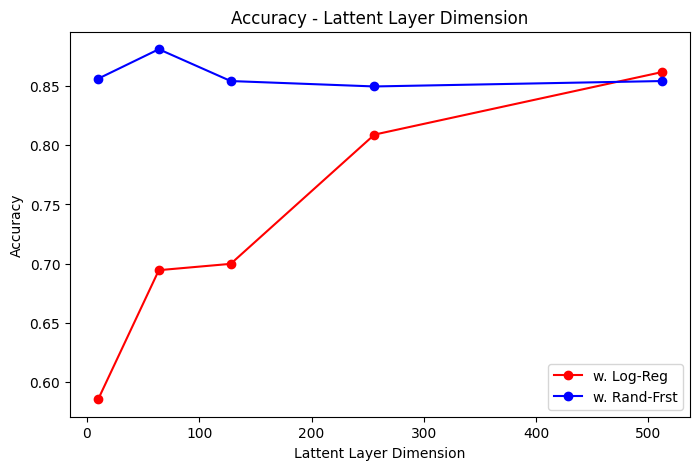

[10 -> w. Log-Reg: 0.5854, w. Rand-Frst: 0.8564]
[64 -> w. Log-Reg: 0.6945, w. Rand-Frst: 0.8812]
[128 -> w. Log-Reg: 0.6998, w. Rand-Frst: 0.8543]
[256 -> w. Log-Reg: 0.8091, w. Rand-Frst: 0.8498]
[512 -> w. Log-Reg: 0.8619, w. Rand-Frst: 0.8543]



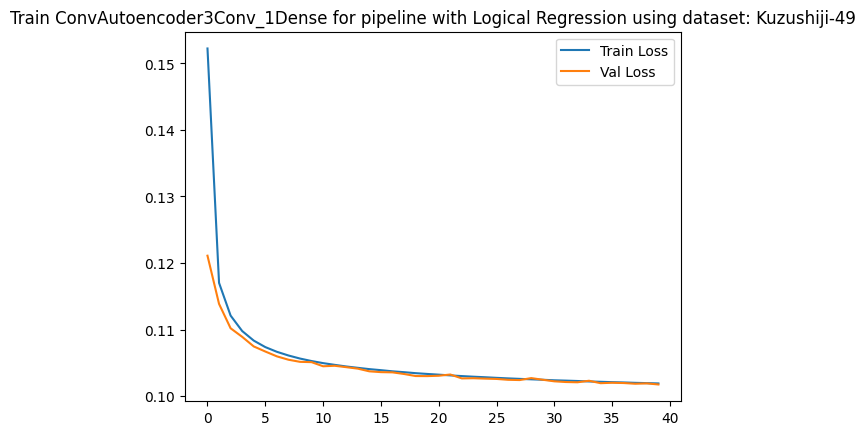

--- ConvAutoencoder3Conv_1Dense with Logistic Regression ---
              precision    recall  f1-score   support

           0       0.89      0.91      0.90       995
           1       0.94      0.94      0.94       962
          10       0.88      0.86      0.87      1052
          11       0.88      0.90      0.89       970
          12       0.77      0.77      0.77       960
          13       0.88      0.87      0.87       669
          14       0.89      0.86      0.88       629
          15       0.81      0.78      0.79      1012
          16       0.92      0.93      0.92       425
          17       0.85      0.85      0.85       953
          18       0.89      0.90      0.90       976
          19       0.86      0.89      0.88      1046
           2       0.90      0.93      0.92      1020
          20       0.82      0.80      0.81      1066
          21       0.82      0.80      0.81       954
          22       0.82      0.81      0.82       321
          23       0

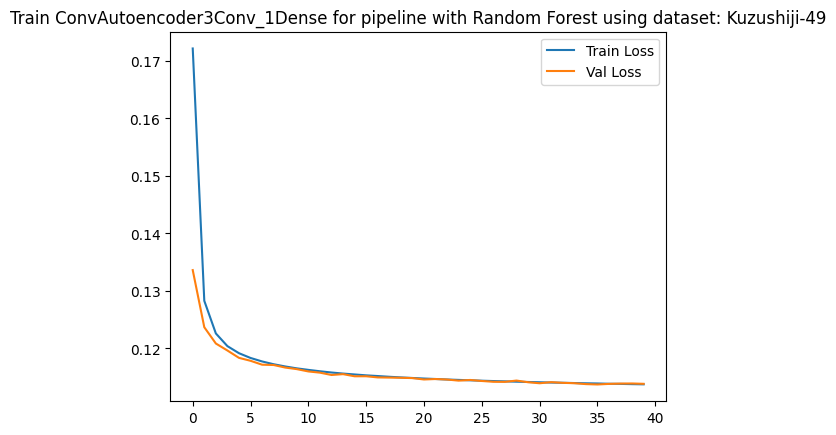

--- ConvAutoencoder3Conv_1Dense with Random Forest ---
              precision    recall  f1-score   support

           0       0.83      0.94      0.88       995
           1       0.92      0.96      0.94       962
          10       0.89      0.89      0.89      1052
          11       0.94      0.88      0.91       970
          12       0.88      0.87      0.87       960
          13       0.86      0.90      0.88       669
          14       0.88      0.84      0.86       629
          15       0.90      0.83      0.86      1012
          16       0.91      0.93      0.92       425
          17       0.82      0.92      0.86       953
          18       0.92      0.92      0.92       976
          19       0.88      0.89      0.89      1046
           2       0.85      0.94      0.89      1020
          20       0.85      0.85      0.85      1066
          21       0.89      0.82      0.85       954
          22       0.89      0.81      0.85       321
          23       0.87   

In [137]:
log_reg = LogisticRegression(max_iter=1000, solver="newton-cg")
rand_frst = RandomForestClassifier(n_estimators=250, random_state=seed)
find_and_eval_best_encoder(utils.Dataset_Select.KUZ_49.value, ConvAutoencoder3Conv_1Dense, latent_dims, log_reg, rand_frst)

Wybrane enkodery do ekstrakcji cech:
- dla regresji logistycznej: 512 neuronów warstwy latentnej
- dla lasu losowego: 64 neurony warstwy latentnej

Dla obydwu wybranych modeli autoenkodera trening przebiega zgodnie z oczekiwaniami. Linie obrazujące wartości funkcji kosztu z każdą epoką osiągają coraz to niższe wartości, a jednocześnie ulegają sporemu wypłaszczeniu. Dotyczy to zarówno zbioru danych treningowych, jak i walidacyjnych.

Jak to zwykle dla klasyfikatora z regresją logistyczną, wraz ze wzrostem liczby neuronów warstwy latentnej, rośnie jakość klasyfikacji osiągając `accuracy=0.86` dla enkodera z 512 neuronami w tejże warstwie. Jest to do tej pory najlepszy wynik dla tego zbioru danych, zostawiający RBM i DBN w tyle o 2p.p. a autoenkoder o 1p.p.

Jeszcze lepszy wynik uzyskujemy aplikując las losowy jako głowę, gdyż w konfiguracji z enkoderem o 64 neuronach w warstwie latentnej osiągamy `accuracy=0.88` - poprawa o kolejne 2p.p. Co ciekawe, liczba neuronów w warstwie latentnej enkodera jest dość mała, przy czym jest bardzo zbliżona do liczby wyszczególnionych klas w zbiorze danych.

### Podsumowanie

Poniższa tabela zbiera wyniki `accuracy` wszystkich modeli w jednym miejscu:

|                                             | MNIST    | Fashion-MNIST | Kuzushiji-MNIST | Kuzushiji-49 |
|---------------------------------------------|----------|---------------|-----------------|--------------|
| RBM                                         | 0.97     | 0.84          | 0.87            | 0.84         |
| DBN                                         | 0.97     | 0.83          | 0.86            | 0.84         |
| Autoenkoder<br>z reg. log.                  | 0.94     | 0.87          | 0.76            | 0.71         |
| Autoenkoder<br>z lasem los.                 | 0.96     | 0.87          | 0.85            | 0.85         |
| Autoenkoder<br>konwolucyjny<br>z reg. log.  | **0.99** | **0.90**      | **0.88**        | **0.86**     |
| Autoenkoder<br>konwolucyjny<br>z lasem los. | 0.97     | 0.88          | **0.88**        | **0.88**     |

Laboratorium dostarczyło bardzo ciekawych wyników które chciałbym wypunktować w następującej liście:
- dostatecznie duży RBM okazuje się bardzo dobry ekstraktorem cech dla dalszej klasyfikacji. Generalnie czym większa warstwa ukryta, tym lepszy wynik klasyfikacji regresji logistycznej
- zwiększanie liczby warst RBM w modelu DBN niekoniecznie przekłada się na lepsze wyniki klasyfikacji, wręcz pojedyńcza warstwa RBM o odpowiedniej liczbie neuronów potrafi zdeklasować głębsze sieci
- autoenkoder, a dokładniej mówiąc część kodująca, nadaje się dobrze jako ekstraktor cech, lecz niekoniecznie enkoder pobrany z autoenkodera o lepszym odzorowaniu danych wejściowych na wyjściu da najlepsze wyniki jako baza klasyfikatora. Można to rozbić na dalsze obserwacje:
    - najlepsze odwzorowanie danych wejściowych na wyjściu niekoniecznie zapewnia autoenkoder o największej liczbie neuronów warstwy latentnej
    - bardzo często głowa regresji logistycznej działa najlepiej z enkoderem o największej liczbie neuronów warstwy latentnej
    - las losowy, jako głowa klasyfikatora, jest mniej wrażliwa na ilość wyjść z enkodera i potrafi dostarczyć najlepsze wyniki nawet dla najmniejszej jej wielkości (10 neuronów)
- prosty autoenkoder nie w każdym przypadku okaże się lepszy od RBM, w naszych testach wyraźną różnicę na korzyść autoenkodera widać przy zbiorze Fashion-MNIST, natomiast wypada on odrobinę słabiej dla pozostałych zbiorów. Rożnicę tę najpewniej dałoby się zniwelować dalszym usprawnianiem autoenkodera, jednakże polecenie jasno mówiło o prostym autoenkodrze i zachęca do usprawnienia swojego rozwiązania w kolejnym punkcie: autoenkoderze konwolucyjnym
    - znaczna różnica na plus dla autoenkodera w przypadku zbioru Fashion-MNIST wiąże się najpewniej z charakaterem danych i faktem, że autoenkoder nie wymaga do funkcjonowania danych zbinaryzowanych. Binaryzacja okazuje się szczególnie dotkliwa dla zbioru Fashion-MNIST i po jej zastosowaniu duża część informacji z każdego obrazka zostaje utracona. Autoenkoder pozwala wyeliminować to zjawisko.
- autoenkoder konwolucyjny pozwala pchnąć jakość klasyfikacji jeszcze dalej, osiągając najlepsze rezultaty w każdym z badanych zbiorów danych. Oczywiście opracowywanie najlepszego wariantu modelu autoekodera konwolucyjnego jest zadaniem bardzo czasochłonnym, a zwłaszcza że bardziej skomplikowany model potrzebuje więcej czasu na trening i ewaluację. Jednakże raz wykonany wysiłek zwraca się w postaci najlepszej ekstrakcji cech dla dalszej klasyfikacji.